<a href="https://colab.research.google.com/github/williambiondi/RecommenderGS/blob/main/DataCleaningGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install altair -q
!pip install altair_viewer -q
!pip install requests -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 7.5 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import re
import altair as alt

In [ ]:
items_df = pd.read_excel("OrdiniGranSasso.xlsx")
purchases_df = pd.read_excel("OrdiniGranSassoDescrizione.xlsx")

#Pulizia dei dati


In [ ]:
purchases_df.dropna(subset=['DescrizioneEstesaInglese'], inplace=True)

In [ ]:
currencies = purchases_df['CustomerCurrencyCode']
currencies.drop_duplicates(inplace=True)

In [ ]:
def exchange_rate(currency):
  KEY = 'MYKEY'
  url = f'http://data.fixer.io/api/latest?access_key={KEY}'
  try:
    response = requests.get(url)
    data = response.json()
    exchange_rate = float(data['rates'][currency])
    return 1/exchange_rate
  except requests.RequestException as e:
    print("error")
    return None

In [ ]:
rates = {}
for currency in currencies:
  rates[currency] = exchange_rate(currency)

In [ ]:
rates

{'EUR': 1.0,
 'NOK': 0.08499454462515324,
 'USD': 0.9287551894196209,
 'CAD': 0.6832346514751719,
 'CHF': 1.0570668087364457,
 'GBP': 1.1659278570479175,
 'TRY': 0.03202691695830377,
 'AUD': 0.6087801932146578,
 'JPY': 0.006354417051879901}

In [ ]:
def to_euro(row, column):
  rate = rates.get(row['CustomerCurrencyCode'], 1)
  return round(row[column] * rate,2)

In [ ]:
purchases_df['UnitPriceTaxEUR'] = purchases_df.apply(lambda x: to_euro(x, 'UnitPriceInclTax'), axis=1)
purchases_df['RefundedEUR'] = purchases_df.apply(lambda x: to_euro(x, 'RefundedAmount'), axis=1)

In [ ]:
purchases_selected = purchases_df[['Id', 'CustomerId', 'CreatedOnUtc', 'RefundedEUR','UnitPriceTaxEUR','Sku']]

In [ ]:
customers_selected = purchases_df[['CustomerId', 'Name']]
customers_selected.drop_duplicates(subset='CustomerId', inplace=True)
customers_selected = customers_selected.reset_index(drop=True)
customers_selected.rename(columns={'Name':'Country'}, inplace=True)

<ipython-input-24-19dfc760e453>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_selected.drop_duplicates(subset='CustomerId', inplace=True)


In [ ]:
items_df = pd.merge(purchases_df, items_df, on='Sku', how='inner')

In [ ]:
items_df.rename(columns={'Sku_x':'Sku', 'UnitPriceTaxEUR':'UnitPrice'}, inplace=True)

In [ ]:
items_selected = items_df[['Sku', 'LocaleValue', 'Categoria','DescrizioneEstesaInglese','UnitPrice']].drop_duplicates('Sku')
items_selected.dropna(subset=['DescrizioneEstesaInglese'], inplace=True)
items_selected = items_selected.reset_index(drop=True)

In [ ]:
items_selected.head()

,Sku,LocaleValue,Categoria,DescrizioneEstesaInglese,UnitPrice
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,NaN,Crew neck sweater in pure merino wool with mic...,130.0
1,A20201312414230005,WAVE PATTERN TURTLENECK,NaN,"Turtleneck sweater in pure merino wool, embell...",160.0
2,A20205711414241046,SALT AND PEPPER STITCH FULL ZIP,NaN,Cardigan in pure extra fine merino wool with t...,180.0
3,A20201312022612852,AIR WOOL ARGYLE CREW NECK,NaN,3-ply moulinè effect Air Wool crew neck sweate...,145.0
4,A20201314022615116,AIR WOOL ARGYLE V NECK,NaN,<p>Argyle Air Wool V-neck sweater. The special...,145.0


In [ ]:
item_map = dict()
for i in range(items_selected.shape[0]):
  item_map[i] = items_selected.loc[i,'Sku']
items_selected['ItemId'] = item_map.keys()
inverted_item_map = {v: k for k, v in item_map.items()}

In [ ]:
user_map = dict()
for i in range(customers_selected.shape[0]):
  user_map[i] = customers_selected.loc[i,'CustomerId']
customers_selected['UserId'] = user_map.keys()
inverted_uid_map = {v: k for k, v in user_map.items()}

Recupero informazioni da Sku

In [ ]:
items_selected['Collection'] = ['Fall-Winter' if sku[0]=='A' else 'Spring-Summer' for sku in items_selected['Sku']]
items_selected['Availability'] = [1 if sku[1:5]=='2023' else 0 for sku in items_selected['Sku']]
items_selected['Color'] = [sku[15:18] for sku in items_selected['Sku']]
items_selected['Gender'] = ['Women' if int(sku[7]) == 2 else 'Men' for sku in items_selected['Sku']]

Recupero categorie e composizione dalla descrizione

In [ ]:
def clean_description(description):
  clean = re.sub(r'<[^>]+>','', description.lower().strip())
  return re.sub(r'[^\w\s]','',clean)

In [ ]:
def get_composition(description, composition_list):
  for word in description.split(" "):
    if word.lower() in composition_list:
      return word.lower()

In [ ]:
composition_list = ['alcantara', 'cashmere','wool', 'cotton', 'nylon', 'viscose', 'eco-feather', 'silk', 'merinos', 'merinowool', 'linen']

In [ ]:
category_set = set()
for category in items_selected['Categoria']:
  if not pd.isna(category):
    for item in category.split(";"):
      category_set.add(item)
  else:
    continue
category_list = list(category_set)

In [ ]:
items_selected['Description'] = items_selected['DescrizioneEstesaInglese'].apply(clean_description)
items_selected.drop(columns=['DescrizioneEstesaInglese'], inplace=True)
items_selected['Composition'] = items_selected['Description'].apply(lambda x: get_composition(x, composition_list))

In [ ]:
wool_map = {'merinos':'wool', 'merinowool': 'wool'}
items_selected['Composition']= items_selected['Composition'].map(lambda x: wool_map.get(x,x))

In [ ]:
items_selected

In [ ]:
category_list

['Pantaloni e Bermuda',
 'Polo, Camicie e T-shirt',
 'Polo, Camicie e Top',
 'Abiti, Pantaloni e Gonne',
 'I classici',
 'Pantaloni',
 'Maglieria, Giacche',
 'Beachwear',
 'Pantaloni e Gonne',
 'Cashmere',
 'Sciarpe e Cappelli',
 'Maglieria',
 'Vintage',
 'Capispalla']

In [ ]:
categories = {
    "Pantaloni e Bermuda": {"pant", "bermuda", "trousers", "shorts"},
    "Cashmere": {"cashmere"},
    "Beachwear": {"beachwear", "swimwear", "bikini", "swimsuit", "swim"},
    "Maglieria": {"knit", "sweater", "cardigan", "wool", "crew", "neck", "crewneck", "turtleneck", "lana"},
    "Pantaloni e Gonne": {"pant", "skirt"},
    "I classici": {"classic", "traditional", "timeless", "waistcoat"},
    "Polo, Camicie e T-shirt": {"polo", "shirt", "t-shirt", "tshirt", "tee", "tracksuit", "sweatshirt"},
    "Abiti, Pantaloni e Gonne": {"dress", "pant", "skirt"},
    "Sciarpe e Cappelli": {"scarf", "hat", "cap"},
    "Capispalla": {"coat", "jacket", "outerwear", "faux", "vest","blouse"},
    "Vintage": {"vintage", "retro", "old-school"},
    "Pantaloni": {"pant","pants", "trousers", "slacks", "joggers"},
    "Giacche": {"jacket", "cardigan"},
    "Polo, Camicie e Top": {"polo", "shirt", "top","tank"}
}

In [ ]:
def get_category(description, categories):
  description = set(description.split(" ")[:20])
  matched = list()
  for category, keywords in categories.items():
    if description.intersection(keywords):
      matched.append(category)
  return matched

In [ ]:
items_selected.rename(columns={'LocaleValue':'ItemName','Categoria':'Category'}, inplace=True)

In [ ]:
for idx, row in items_selected.iterrows():
  if pd.isna(row['Category']):
    predicted = get_category(row['Description'], categories)
    if predicted:
      items_selected.at[idx,'Category'] = predicted
  else:
    items_selected.at[idx,'Category'] = row['Category'].split(";")

In [ ]:
purchases_selected['UserId'] = purchases_selected['CustomerId'].map(inverted_uid_map)
purchases_selected['ItemId'] = purchases_selected['Sku'].map(inverted_item_map)

<ipython-input-46-9e537e27da12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases_selected['UserId'] = purchases_selected['CustomerId'].map(inverted_uid_map)
<ipython-input-46-9e537e27da12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases_selected['ItemId'] = purchases_selected['Sku'].map(inverted_item_map)


In [ ]:
purchases_selected = purchases_selected[['Id','UserId','ItemId','CreatedOnUtc', 'RefundedEUR', 'UnitPriceTaxEUR']]

In [ ]:
items_selected.to_csv('ArticoliGransasso.csv')
purchases_selected.to_csv('OrdiniGransasso.csv')
customers_selected.to_csv('ClientiGransasso.csv')

In [4]:
#items_selected = pd.read_csv('ArticoliGransasso.csv')
#customers_selected = pd.read_csv('ClientiGransasso.csv')
#purchases_selected = pd.read_csv('OrdiniGransasso.csv')

items = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ArticoliGransasso.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ClientiGransasso.csv')
purchases = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/OrdiniGransasso.csv')
items.drop(columns=['Unnamed: 0'], inplace=True)
customers.drop(columns=['Unnamed: 0'], inplace=True)
purchases.drop(columns=['Unnamed: 0'], inplace=True)

#Analitiche

In [10]:
# Inspect the structure of the datasets
print(items.info())
print(customers.info())
print(purchases.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3497 entries, 0 to 3496
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sku           3497 non-null   object 
 1   ItemName      3497 non-null   object 
 2   Category      3497 non-null   object 
 3   UnitPrice     3497 non-null   float64
 4   ItemId        3497 non-null   int64  
 5   Collection    3497 non-null   object 
 6   Availability  3497 non-null   int64  
 7   Color         3497 non-null   int64  
 8   Gender        3497 non-null   object 
 9   Description   3497 non-null   object 
 10  Composition   3387 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 300.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5246 entries, 0 to 5245
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerId  5246 non-null   int64 
 1   Country     5246 non-null   object

In [11]:
# Display summary statistics
print(items.describe())
print(customers.describe())
print(purchases.describe())


         UnitPrice       ItemId  Availability        Color
count  3497.000000  3497.000000   3497.000000  3497.000000
mean    244.765851  1748.000000      0.279668   330.451244
std     155.323114  1009.641273      0.448900   274.878933
min       0.000000     0.000000      0.000000     1.000000
25%     150.000000   874.000000      0.000000    93.000000
50%     205.000000  1748.000000      0.000000   241.000000
75%     280.000000  2622.000000      1.000000   598.000000
max    2126.850000  3496.000000      1.000000   997.000000
         CustomerId       UserId
count  5.246000e+03  5246.000000
mean   1.278944e+07  2622.500000
std    5.265706e+06  1514.534087
min    1.060900e+04     0.000000
25%    9.677075e+06  1311.250000
50%    1.238091e+07  2622.500000
75%    1.686698e+07  3933.750000
max    2.580643e+07  5245.000000
                 Id        UserId        ItemId   RefundedEUR  UnitPriceTaxEUR
count  19872.000000  19872.000000  19872.000000  19872.000000     19872.000000
mean   14261.0

In [39]:
len(purchases[purchases["RefundedEUR"] !=0])

3509

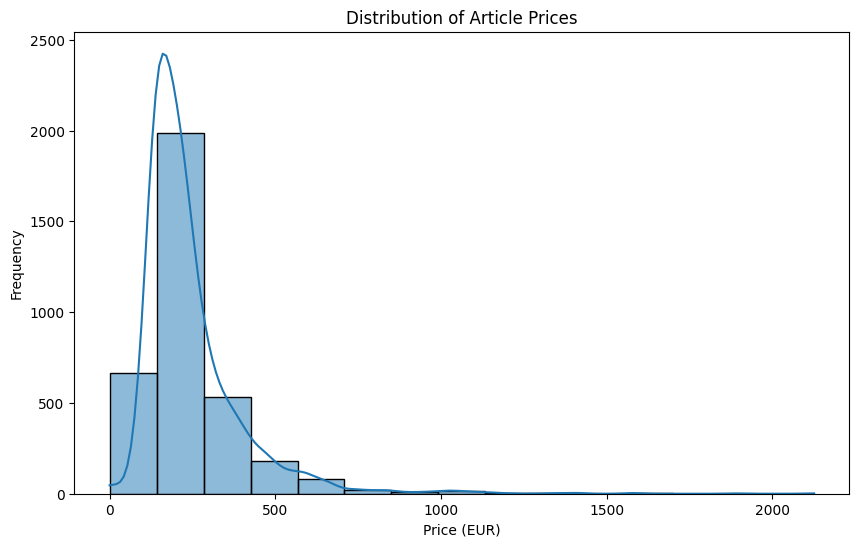

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(items['UnitPrice'], bins=15, kde=True)
plt.title('Distribution of Article Prices')
plt.xlabel('Price (EUR)')
plt.ylabel('Frequency')
plt.show()


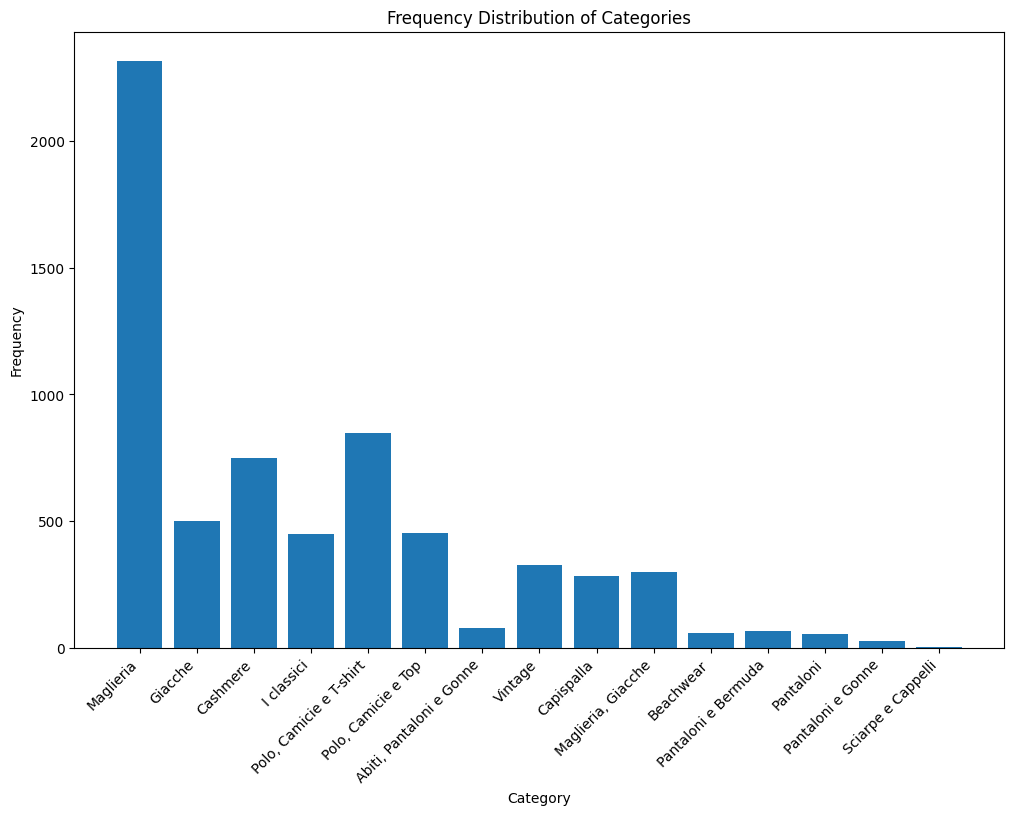

In [23]:
import ast
from collections import Counter

all_categories = [category for sublist in items['Category'] for category in sublist]
category_counts = Counter(all_categories)
categories = list(category_counts.keys())
frequencies = list(category_counts.values())

plt.figure(figsize=(12, 8))
plt.bar(categories, frequencies)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.title('Frequency Distribution of Categories')
plt.show()

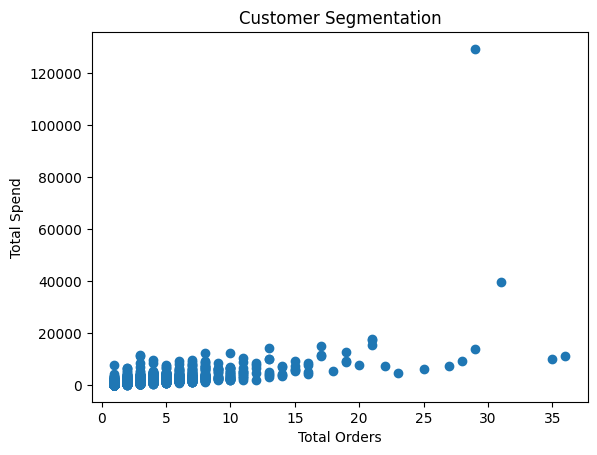

In [33]:
total_per_order = purchases.merge(items, on='ItemId').groupby(['Id','UserId'])['UnitPrice'].sum().reset_index()
customer_orders = total_per_order.groupby('UserId').size()
customer_spend = total_per_order.groupby('UserId')['UnitPrice'].sum()

# Visualize customer segments based on order count and total spend
plt.scatter(customer_orders, customer_spend)
plt.title('Customer Segmentation')
plt.xlabel('Total Orders')
plt.ylabel('Total Spend')
plt.show()


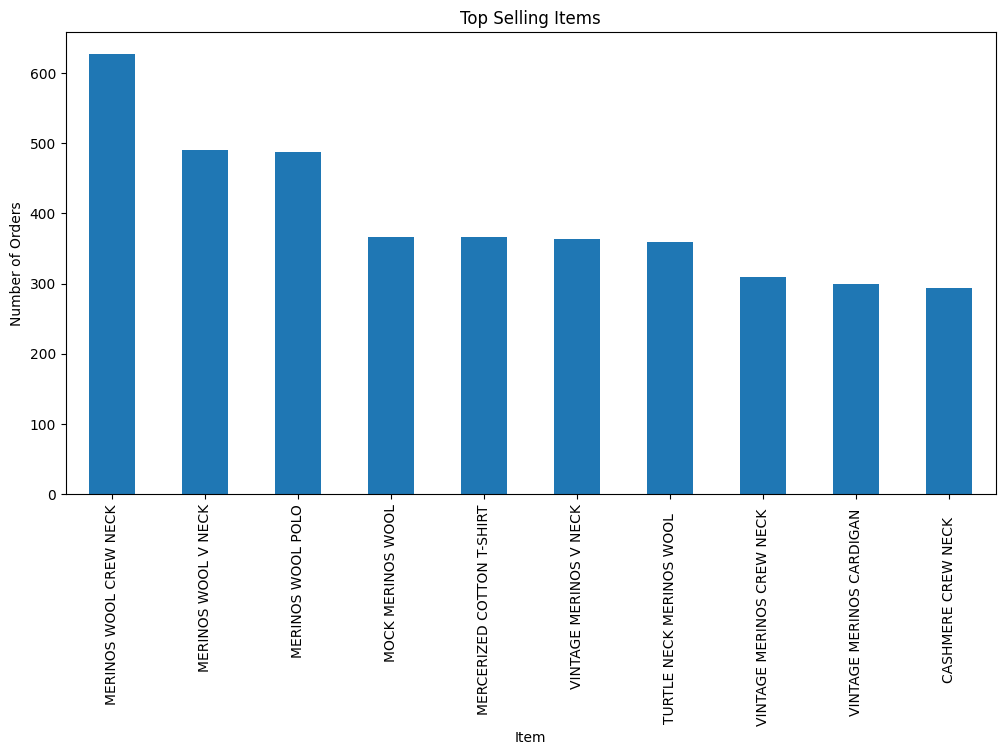

In [36]:
item_sales = purchases.merge(items, on='ItemId').groupby('ItemName').size().sort_values(ascending=False)

item_sales.head(10).plot(kind='bar', figsize=(12, 6), title='Top Selling Items')
plt.xlabel('Item')
plt.ylabel('Number of Orders')
plt.show()


In [44]:
total_per_order = purchases.merge(items, on='ItemId').groupby(['Id'])['UnitPrice'].sum().reset_index()


In [47]:
total_per_order

,Id,UnitPrice,Range
0,8812,130.00,"[0, 500)"
1,8813,340.00,"[0, 500)"
2,8814,290.00,"[0, 500)"
3,8815,235.00,"[0, 500)"
4,8816,220.00,"[0, 500)"
...,...,...,...
10772,19646,264.27,NaN
10773,19647,395.00,NaN
10774,19648,230.00,NaN
10775,19649,297.20,NaN


In [45]:
bins = list(range(0, int(items['UnitPrice'].max()) + 500, 500))
total_per_order['Range']=pd.cut(items['UnitPrice'], bins = bins, right=False).astype(str)

In [46]:
price_chart = alt.Chart(total_per_order).mark_bar().encode(
    alt.X('UnitPrice:Q', bin=alt.Bin(step=500), title='Price(EUR)'),
    alt.Y('count()', title='Orders'),
    tooltip=[alt.Tooltip('Range', title='Fascia di Prezzo'), alt.Tooltip('count()', title='Numero Articoli')]
).properties(title='Total spenrt for single order')
alt.hconcat(price_chart)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

In [ ]:
order_customer = purchases_selected.merge(customers_selected, on='UserId')
full = order_customer.merge(items_selected, on='ItemId')
full.head()
orders = full.groupby(['Id','Country'])['UnitPrice'].sum().reset_index()
mean_order_per_country = full.groupby(['Country'])['UnitPrice'].mean().reset_index()

In [ ]:
nations_filter = alt.selection_multi(fields=["Country"])
nations_chart = alt.Chart(orders).mark_bar().encode(
    x="count()",
    y=alt.Y("Country:N"),
    color=alt.condition(nations_filter,
        alt.Color("Name:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(title='Ordini per nazione',selection=nations_filter)
nations_chart_mean_expense = alt.Chart(mean_order_per_country).mark_bar().encode(
    x="UnitPrice:Q",
    y=alt.Y("Country:N"),
    color=alt.condition(nations_filter,
        alt.Color("Country:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(title='Spesa media per singolo ordine per nazione',selection=nations_filter)
alt.hconcat(nations_chart,nations_chart_mean_expense)

alt.HConcatChart(...)